In [ ]:
!pip install pandas numpy pyinform matplotlib seaborn


import pandas as pd
import numpy as np
import pyinform
import matplotlib.pyplot as plt
import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 2.5 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of dates with signals: 22
    Bin Count  Time Lag  Transfer Entropy Candidate
0           2         1          0.083523     Trump
1           2         1          0.167310     Biden
2           2         2          0.365045     Trump
3           2         2          0.049258     Biden
4           2         3          0.238208     Trump
..        ...       ...               ...       ...
85         10         3          0.063472     Biden
86         10         4          0.441751     Trump
87         10         4          0.232833     Biden
88         10         5          0.422180     Trump
89         10         5          0.187279     Biden

[90 rows x 4 columns]


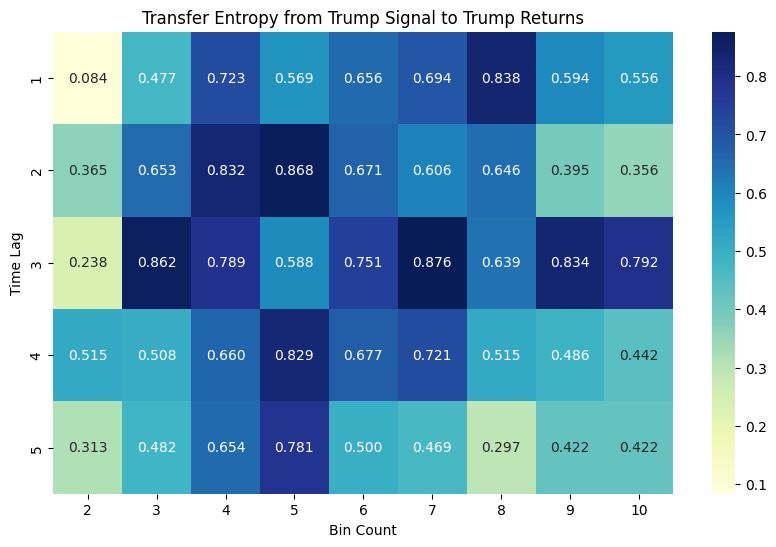

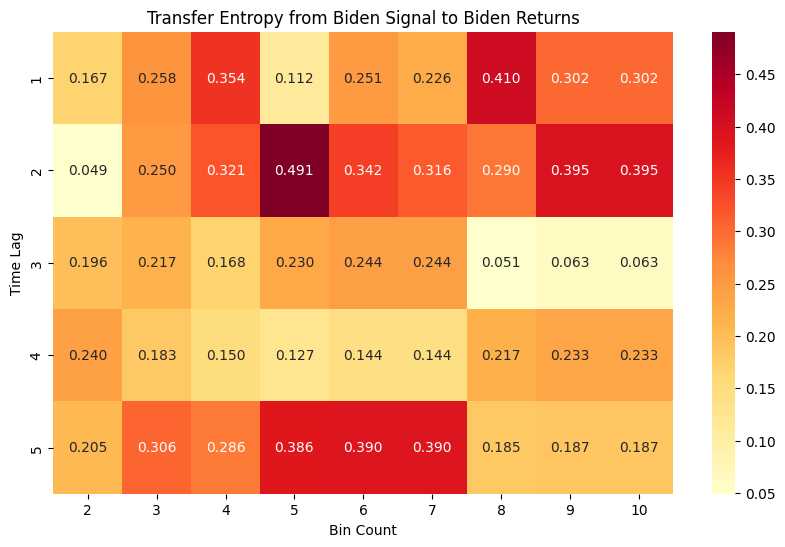

In [ ]:
import pandas as pd
import numpy as np
import pyinform
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Define the File Paths
data_folder = '/content/drive/My Drive/Polymarket_TE/'
signals_file = data_folder + 'daily_signal.csv'
returns_file = data_folder + 'prices_with_returns.csv'

# Step 3: Load the Data
signals_df = pd.read_csv(signals_file)
returns_df = pd.read_csv(returns_file)

# Step 4: Preprocess the Data
signals_df['Date'] = pd.to_datetime(signals_df['Date'])
returns_df['Date'] = pd.to_datetime(returns_df['Date (UTC)'])

# Standardize column names in returns_df
returns_df.rename(columns={'Date': 'Date', 'Trump Returns': 'Trump returns', 'Biden Returns': 'Biden returns'}, inplace=True)

# Merge the data on 'Date' using 'inner' join to keep only dates with signals
data_df = pd.merge(
    returns_df,
    signals_df[['Date', 'Trump signal shifted', 'Biden signal shifted']],
    on='Date',
    how='inner'
)

# Verify the number of dates with signals
num_dates = data_df['Date'].nunique()
print(f"Number of dates with signals: {num_dates}")

# Step 5: Discretize the Returns
bin_numbers = range(2, 11)  # Bin counts from 2 to 10
time_lags = range(1, 6)     # Time lags from 1 to 5

# Initialize a list to store results
results_list = []

# Loop over bin counts and time lags
for num_bins in bin_numbers:
    # Discretize the returns using equal frequency binning
    quantiles = np.linspace(0, 1, num_bins + 1)

    # For Trump
    trump_bin_edges = data_df['Trump returns'].quantile(quantiles).unique()
    data_df['Trump returns discrete'] = pd.cut(
        data_df['Trump returns'],
        bins=trump_bin_edges,
        labels=False,
        include_lowest=True
    ).astype(int)

    # For Biden
    biden_bin_edges = data_df['Biden returns'].quantile(quantiles).unique()
    data_df['Biden returns discrete'] = pd.cut(
        data_df['Biden returns'],
        bins=biden_bin_edges,
        labels=False,
        include_lowest=True
    ).astype(int)

    for lag in time_lags:
        # Create a copy to avoid modifying the original DataFrame
        data_lagged = data_df.copy()

        # Shift the returns by -lag to align future returns with current signals
        data_lagged['Trump returns discrete lagged'] = data_lagged['Trump returns discrete'].shift(-lag)
        data_lagged['Biden returns discrete lagged'] = data_lagged['Biden returns discrete'].shift(-lag)

        # Drop rows with NaN values after shifting
        data_lagged.dropna(subset=['Trump returns discrete lagged', 'Trump signal shifted'], inplace=True)
        data_lagged.dropna(subset=['Biden returns discrete lagged', 'Biden signal shifted'], inplace=True)

        # Ensure lagged returns are integers
        data_lagged['Trump returns discrete lagged'] = data_lagged['Trump returns discrete lagged'].astype(int)
        data_lagged['Biden returns discrete lagged'] = data_lagged['Biden returns discrete lagged'].astype(int)

        # Prepare source and target arrays for Trump
        source_trump = data_lagged['Trump signal shifted'].values
        target_trump = data_lagged['Trump returns discrete lagged'].values

        # Compute Transfer Entropy for Trump
        if len(source_trump) > 1 and len(target_trump) > 1:
            te_trump = pyinform.transferentropy.transfer_entropy(source_trump, target_trump, k=1)
        else:
            te_trump = np.nan  # Not enough data points

        # Store the result for Trump
        results_list.append({
            'Bin Count': num_bins,
            'Time Lag': lag,
            'Transfer Entropy': te_trump,
            'Candidate': 'Trump'
        })

        # Prepare source and target arrays for Biden
        source_biden = data_lagged['Biden signal shifted'].values
        target_biden = data_lagged['Biden returns discrete lagged'].values

        # Compute Transfer Entropy for Biden
        if len(source_biden) > 1 and len(target_biden) > 1:
            te_biden = pyinform.transferentropy.transfer_entropy(source_biden, target_biden, k=1)
        else:
            te_biden = np.nan  # Not enough data points

        # Store the result for Biden
        results_list.append({
            'Bin Count': num_bins,
            'Time Lag': lag,
            'Transfer Entropy': te_biden,
            'Candidate': 'Biden'
        })

# Step 6: Create the Results DataFrame
results = pd.DataFrame(results_list)

# Step 7: Process and Display the Results
# Convert 'Bin Count' and 'Time Lag' to integers
results['Bin Count'] = results['Bin Count'].astype(int)
results['Time Lag'] = results['Time Lag'].astype(int)

# Display the results
print(results)

# Step 8: Visualize the Results (Optional)
if not results['Transfer Entropy'].isnull().all():
    # Pivot the DataFrame for Trump
    pivot_table_trump = results[results['Candidate'] == 'Trump'].pivot(
        index='Time Lag', columns='Bin Count', values='Transfer Entropy'
    )

    # Pivot the DataFrame for Biden
    pivot_table_biden = results[results['Candidate'] == 'Biden'].pivot(
        index='Time Lag', columns='Bin Count', values='Transfer Entropy'
    )

    # Plot heatmap for Trump
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        pivot_table_trump,
        annot=True,
        fmt=".3f",
        cmap="YlGnBu"
    )
    plt.title('Transfer Entropy from Trump Signal to Trump Returns')
    plt.ylabel('Time Lag')
    plt.xlabel('Bin Count')
    plt.show()

    # Plot heatmap for Biden
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        pivot_table_biden,
        annot=True,
        fmt=".3f",
        cmap="YlOrRd"
    )
    plt.title('Transfer Entropy from Biden Signal to Biden Returns')
    plt.ylabel('Time Lag')
    plt.xlabel('Bin Count')
    plt.show()
else:
    print("Not enough data points to visualize Transfer Entropy.")


The code above is very good, don't lose it - it's the first code which successfully ran TE. Next cell modifies it to include significance analysis, and adjusting the heatmaps on that.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Columns in signals_df before removing duplicates:
['Event Name', 'Date', 'signal', 'confidence', 'Trump signal', 'Biden signal ', 'Trump signal shifted', 'Biden signal shifted', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13']

Duplicate columns in returns_df:
Index([], dtype='object')

No duplicate 'Date' columns found in returns_df.

Columns in returns_df after removing duplicates:
['Date', 'Timestamp (UTC)', 'Donald Trump', 'Joe Biden', 'Trump returns', 'Biden returns']

Columns in signals_df before removing 'Unnamed' columns:
['Event Name', 'Date', 'signal', 'confidence', 'Trump signal', 'Biden signal ', 'Trump signal shifted', 'Biden signal shifted', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13']

Removed 'Unnamed' columns: ['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed

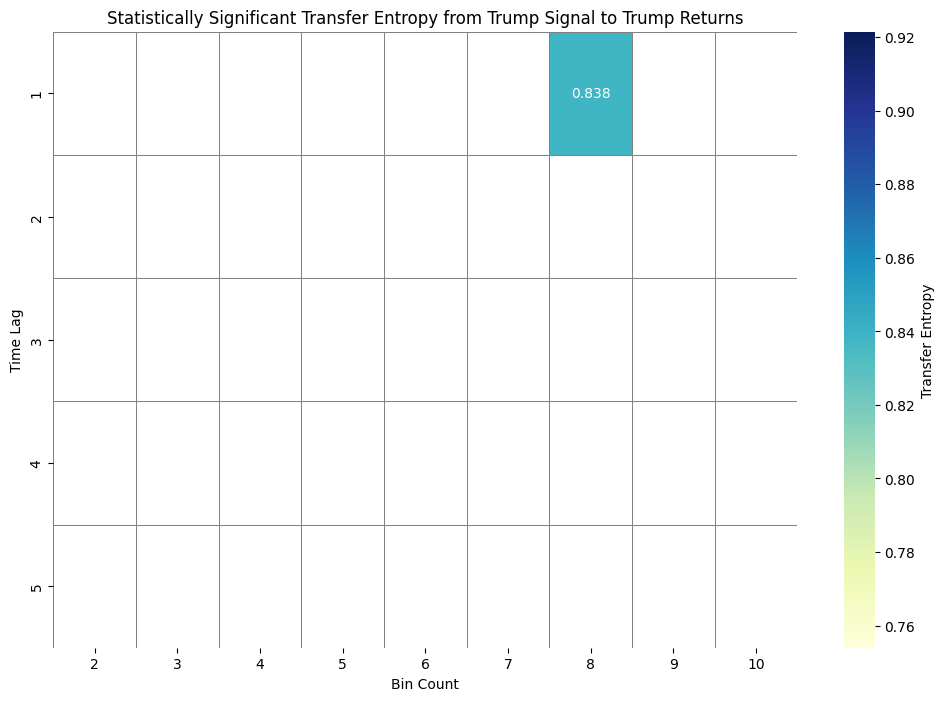

Trump heatmap saved to /content/drive/My Drive/Polymarket_TE/plots/trump_transfer_entropy_heatmap.png


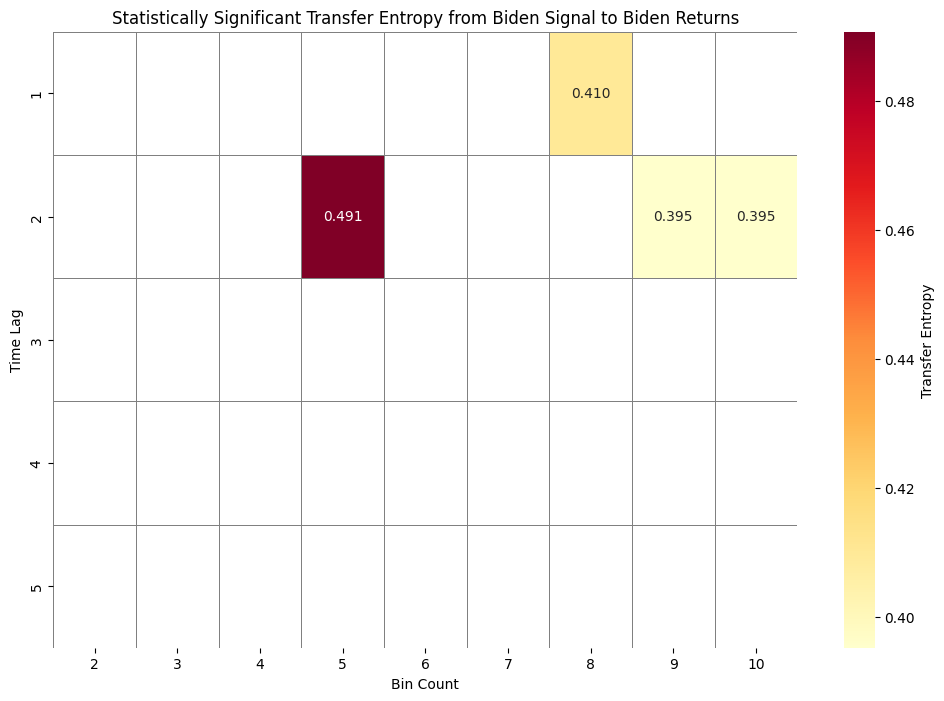

Biden heatmap saved to /content/drive/My Drive/Polymarket_TE/plots/biden_transfer_entropy_heatmap.png

Results DataFrame saved to /content/drive/My Drive/Polymarket_TE/results/transfer_entropy_results.csv


In [ ]:
import pandas as pd
import numpy as np
import pyinform
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Step 1: Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Define the File Paths
data_folder = '/content/drive/My Drive/Polymarket_TE/'
signals_file = os.path.join(data_folder, 'daily_signal.csv')
returns_file = os.path.join(data_folder, 'prices_with_returns.csv')

# Step 3: Load the Data
signals_df = pd.read_csv(signals_file)
returns_df = pd.read_csv(returns_file)

# Step 4: Preprocess the Data
# Convert 'Date' columns to datetime
signals_df['Date'] = pd.to_datetime(signals_df['Date'])
returns_df['Date (UTC)'] = pd.to_datetime(returns_df['Date (UTC)'])

# Standardize column names in returns_df
returns_df.rename(columns={
    'Date (UTC)': 'Date',
    'Trump Returns': 'Trump returns',
    'Biden Returns': 'Biden returns'
}, inplace=True)

# Inspect columns in signals_df
print("Columns in signals_df before removing duplicates:")
print(signals_df.columns.tolist())

# Check for duplicate 'Date' columns
duplicate_columns = returns_df.columns[returns_df.columns.duplicated()].unique()
print("\nDuplicate columns in returns_df:")
print(duplicate_columns)

# Remove duplicate 'Date' columns in returns_df, keeping the first occurrence
if 'Date' in duplicate_columns:
    returns_df = returns_df.loc[:, ~returns_df.columns.duplicated()]
    print("\nDuplicate 'Date' columns removed from returns_df.")
else:
    print("\nNo duplicate 'Date' columns found in returns_df.")

# Verify the columns after removal
print("\nColumns in returns_df after removing duplicates:")
print(returns_df.columns.tolist())

# Inspect columns in signals_df after initial cleaning
print("\nColumns in signals_df before removing 'Unnamed' columns:")
print(signals_df.columns.tolist())

# Remove 'Unnamed' columns from signals_df
unnamed_cols = [col for col in signals_df.columns if col.startswith('Unnamed')]
if unnamed_cols:
    signals_df = signals_df.drop(columns=unnamed_cols)
    print(f"\nRemoved 'Unnamed' columns: {unnamed_cols}")
else:
    print("\nNo 'Unnamed' columns to remove from signals_df.")

# Verify the columns after removing 'Unnamed' columns
print("\nColumns in signals_df after removing 'Unnamed' columns:")
print(signals_df.columns.tolist())

# Ensure there's only one 'Date' column in signals_df
if signals_df.columns.tolist().count('Date') == 1:
    print("\n'Date' column is unique in signals_df.")
else:
    print("\n'Date' column is still duplicated in signals_df.")

# Standardize column names in signals_df (optional, based on case sensitivity)
#signals_df.columns = signals_df.columns.str.strip().str.lower()
#signals_df = signals_df.rename(columns={
 #   'event name': 'Event Name',
   # 'date': 'Date',
   # 'signal': 'signal',
  #  'trump signal': 'Trump signal',
   # 'biden signal': 'Biden signal',
   # 'trump signal shifted': 'Trump signal shifted',
   # 'biden signal shifted': 'Biden signal shifted'
#})

# Verify the columns after standardizing names
print("\nColumns in signals_df after standardizing names:")
print(signals_df.columns.tolist())

# Merge the data on 'Date' using inner join to keep only dates with signals
data_df = pd.merge(
    returns_df,
    signals_df[['Date', 'Trump signal shifted', 'Biden signal shifted']],
    on='Date',
    how='inner'
)

# Verify the number of dates with signals
num_dates = data_df['Date'].nunique()
print(f"\nNumber of dates with signals after merge: {num_dates}")

# Step 5: Discretize the Returns and Compute Transfer Entropy with Significance Testing
# Define bin counts and time lags
bin_numbers = range(2, 11)  # Bin counts from 2 to 10
time_lags = range(1, 6)     # Time lags from 1 to 5

# Initialize a list to store results
results_list = []

# Define significance level
alpha = 0.05

# Define number of surrogates for testing
num_surrogates = 1000

# Loop over bin counts and time lags
for num_bins in bin_numbers:
    # Discretize the returns using equal frequency binning
    quantiles = np.linspace(0, 1, num_bins + 1)

    # For Trump
    try:
        trump_bin_edges = data_df['Trump returns'].quantile(quantiles).unique()
        data_df['Trump returns discrete'] = pd.cut(
            data_df['Trump returns'],
            bins=trump_bin_edges,
            labels=False,
            include_lowest=True
        ).astype(int)
    except ValueError as e:
        print(f"Error in discretizing Trump returns with {num_bins} bins: {e}")
        continue  # Skip to the next bin count

    # For Biden
    try:
        biden_bin_edges = data_df['Biden returns'].quantile(quantiles).unique()
        data_df['Biden returns discrete'] = pd.cut(
            data_df['Biden returns'],
            bins=biden_bin_edges,
            labels=False,
            include_lowest=True
        ).astype(int)
    except ValueError as e:
        print(f"Error in discretizing Biden returns with {num_bins} bins: {e}")
        continue  # Skip to the next bin count

    for lag in time_lags:
        # Create a copy to avoid modifying the original DataFrame
        data_lagged = data_df.copy()

        # Shift the returns by -lag to align future returns with current signals
        data_lagged['Trump returns discrete lagged'] = data_lagged['Trump returns discrete'].shift(-lag)
        data_lagged['Biden returns discrete lagged'] = data_lagged['Biden returns discrete'].shift(-lag)

        # Drop rows with NaN values after shifting
        data_lagged.dropna(subset=['Trump returns discrete lagged', 'Trump signal shifted'], inplace=True)
        data_lagged.dropna(subset=['Biden returns discrete lagged', 'Biden signal shifted'], inplace=True)

        # Ensure lagged returns are integers
        data_lagged['Trump returns discrete lagged'] = data_lagged['Trump returns discrete lagged'].astype(int)
        data_lagged['Biden returns discrete lagged'] = data_lagged['Biden returns discrete lagged'].astype(int)

        # Prepare source and target arrays for Trump
        source_trump = data_lagged['Trump signal shifted'].values
        target_trump = data_lagged['Trump returns discrete lagged'].values

        # Compute Observed TE for Trump
        if len(source_trump) > 1 and len(target_trump) > 1:
            te_trump = pyinform.transferentropy.transfer_entropy(source_trump, target_trump, k=1)

            # Perform surrogate testing for Trump
            surrogate_te_trump = []
            for _ in range(num_surrogates):
                shuffled_source_trump = np.random.permutation(source_trump)
                surrogate_te = pyinform.transferentropy.transfer_entropy(shuffled_source_trump, target_trump, k=1)
                surrogate_te_trump.append(surrogate_te)

            # Calculate p-value for Trump
            count_trump = sum(te >= te_trump for te in surrogate_te_trump)
            p_value_trump = (count_trump + 1) / (num_surrogates + 1)  # Adding 1 for continuity

            # Determine significance for Trump
            significant_trump = p_value_trump <= alpha
        else:
            te_trump = np.nan
            p_value_trump = np.nan
            significant_trump = False

        # Store the result for Trump
        results_list.append({
            'Bin Count': num_bins,
            'Time Lag': lag,
            'Transfer Entropy': te_trump,
            'P-Value': p_value_trump,
            'Significant': significant_trump,
            'Candidate': 'Trump'
        })

        # Prepare source and target arrays for Biden
        source_biden = data_lagged['Biden signal shifted'].values
        target_biden = data_lagged['Biden returns discrete lagged'].values

        # Compute Observed TE for Biden
        if len(source_biden) > 1 and len(target_biden) > 1:
            te_biden = pyinform.transferentropy.transfer_entropy(source_biden, target_biden, k=1)

            # Perform surrogate testing for Biden
            surrogate_te_biden = []
            for _ in range(num_surrogates):
                shuffled_source_biden = np.random.permutation(source_biden)
                surrogate_te = pyinform.transferentropy.transfer_entropy(shuffled_source_biden, target_biden, k=1)
                surrogate_te_biden.append(surrogate_te)

            # Calculate p-value for Biden
            count_biden = sum(te >= te_biden for te in surrogate_te_biden)
            p_value_biden = (count_biden + 1) / (num_surrogates + 1)  # Adding 1 for continuity

            # Determine significance for Biden
            significant_biden = p_value_biden <= alpha
        else:
            te_biden = np.nan
            p_value_biden = np.nan
            significant_biden = False

        # Store the result for Biden
        results_list.append({
            'Bin Count': num_bins,
            'Time Lag': lag,
            'Transfer Entropy': te_biden,
            'P-Value': p_value_biden,
            'Significant': significant_biden,
            'Candidate': 'Biden'
        })

# Step 6: Create the Results DataFrame
results = pd.DataFrame(results_list)

# Convert 'Bin Count' and 'Time Lag' to integers for consistency
results['Bin Count'] = results['Bin Count'].astype(int)
results['Time Lag'] = results['Time Lag'].astype(int)

# Display the first few rows of the results
print("\nFirst few rows of the results DataFrame:")
print(results.head())

# Step 7: Pivot the DataFrame for Heatmap Creation
# Pivot the DataFrame for Trump
pivot_table_trump = results[results['Candidate'] == 'Trump'].pivot(
    index='Time Lag', columns='Bin Count', values='Transfer Entropy'
)

# Pivot the Significance DataFrame for Trump
significance_trump = results[results['Candidate'] == 'Trump'].pivot(
    index='Time Lag', columns='Bin Count', values='Significant'
)

# Pivot the DataFrame for Biden
pivot_table_biden = results[results['Candidate'] == 'Biden'].pivot(
    index='Time Lag', columns='Bin Count', values='Transfer Entropy'
)

# Pivot the Significance DataFrame for Biden
significance_biden = results[results['Candidate'] == 'Biden'].pivot(
    index='Time Lag', columns='Bin Count', values='Significant'
)

# Step 8: Create and Save Heatmaps with Significance Masking
def create_and_save_heatmap(pivot_table, significance_table, candidate_name, cmap, filename):
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        pivot_table,
        annot=True,
        fmt=".3f",
        cmap=cmap,
        mask=~significance_table,  # Mask non-significant cells
        cbar_kws={'label': 'Transfer Entropy'},
        linewidths=.5,
        linecolor='gray'
    )
    plt.title(f'Statistically Significant Transfer Entropy from {candidate_name} Signal to {candidate_name} Returns')
    plt.ylabel('Time Lag')
    plt.xlabel('Bin Count')

    # Save the figure
    heatmap_file = os.path.join(plots_folder, filename)
    plt.savefig(heatmap_file, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"{candidate_name} heatmap saved to {heatmap_file}")

# Ensure the plots folder exists
plots_folder = os.path.join(data_folder, 'plots')
os.makedirs(plots_folder, exist_ok=True)

# Create and save heatmap for Trump
create_and_save_heatmap(
    pivot_table_trump,
    significance_trump,
    'Trump',
    'YlGnBu',
    'trump_transfer_entropy_heatmap.png'
)

# Create and save heatmap for Biden
create_and_save_heatmap(
    pivot_table_biden,
    significance_biden,
    'Biden',
    'YlOrRd',
    'biden_transfer_entropy_heatmap.png'
)

# Step 9: Save the Results DataFrame to Google Drive
# Define the file path for the results CSV
results_folder = os.path.join(data_folder, 'results')
os.makedirs(results_folder, exist_ok=True)
results_csv_path = os.path.join(results_folder, 'transfer_entropy_results.csv')

# Save the DataFrame to CSV
results.to_csv(results_csv_path, index=False)

print(f"\nResults DataFrame saved to {results_csv_path}")


This is it


